# Convolutional Neural Network
In this notebook, we are going to implement a Convolutional Neural Network for text classification

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
from sklearn import utils
from sklearn.model_selection import train_test_split 
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
import datetime

print(datetime.datetime.now())

Using TensorFlow backend.


2019-11-20 21:47:09.081543


We load the dataset and keep the columns that we are going to use

In [2]:
%%time
df = pd.read_json('IMDB_reviews.json', lines=True)
df = df[['is_spoiler', 'review_text']]
df.is_spoiler = df.is_spoiler.astype(int)
df.head()

Wall time: 13.2 s


,is_spoiler,review_text
0,1,"In its Oscar year, Shawshank Redemption (writt..."
1,1,The Shawshank Redemption is without a doubt on...
2,1,I believe that this film is the best story eve...
3,1,"**Yes, there are SPOILERS here**This film has ..."
4,1,At the heart of this extraordinary movie is a ...


## 1.- Balancing and Preprocessing
### 1.1.- Balancing
First, we are going to apply a grid search to find the best parameters, that's why in this case the subset is smaller, we do this due to the computation times (Training a model with the complete set takes more than 6 hours, so we will use the complete dataset once we have the best hyperparameters). <br> <br>
Since the data is not balanced (see previous notebooks), we use undersampling to obtain a balanced subset

Random Undersampling


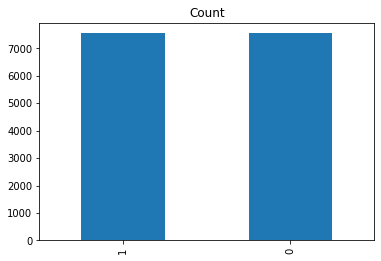

1    7546
0    7546
Name: is_spoiler, dtype: int64
Wall time: 196 ms


In [3]:
%%time
# Class count
count_not_spoiler, count_spoiler = df.is_spoiler.value_counts()

# Divide by class
df_spoiler = df[ df['is_spoiler'] == 1 ]
df_not_spoiler = df[ df['is_spoiler'] == 0 ]

# Random undersampling
# We reduce the number of not spoiler to the number of spoiler
# We use floor division (//)
df_not_spoiler_under = df_not_spoiler.sample(int(count_spoiler//20))
df_spoiler_under = df_spoiler.sample(int(count_spoiler//20))
df_balanced = pd.concat([df_not_spoiler_under, df_spoiler_under], axis=0)

# We randomize the order of the rows
df_balanced = df_balanced.sample(frac=1)

# The resulting dataset is balanced (100.616 reviews with spoilers and 100.616 without spoilers)
print('Random Undersampling')
df_balanced.is_spoiler.value_counts().plot(kind='bar', title='Count')
plt.show()
print(df_balanced.is_spoiler.value_counts())

We split the balanced dataset in training and test, The function returns a Numpy array

In [4]:
df_balanced.columns

Index(['is_spoiler', 'review_text'], dtype='object')

In [5]:
reviews = df_balanced['review_text'].values
y = df_balanced['is_spoiler'].values

# Splitting in training and test set
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, test_size=0.3, random_state=1000)

### 1.2- Preprocessing
We define the tokenize() function created in previous notebooks with the only difference that this time it returns a simple string instead of a list of strings. <br>
The name of the function has been changed to preprocess to avoid confusions with the keras function that has the same name

In [30]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    precision = history.history['precision_m']
    val_precision = history.history['val_precision_m']
    
    recall = history.history['recall_m']
    val_recall = history.history['val_recall_m']
    
    f1 = history.history['f1_m']
    val_f1 = history.history['val_f1_m']
    
    x = range(1, len(acc) + 1)
    
    
    plt.figure(figsize=(24, 10))
    
    plt.subplot(2, 2, 1)
    plt.ylim(0., 1.)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(x, precision, 'b', label='Training precision')
    plt.plot(x, val_precision, 'r', label='Validation precision')
    plt.ylim(0., 1.)
    plt.title('Training and validation precision')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(x, recall, 'b', label='Training recall')
    plt.plot(x, val_recall, 'r', label='Validation recall')
    plt.ylim(0., 1.)
    plt.title('Training and validation recall')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(x, f1, 'b', label='Training f1-score')
    plt.plot(x, val_f1, 'r', label='Validation f1-score')
    plt.ylim(0., 1.)
    plt.title('Training and validation f1-score')
    plt.legend()
    plt.show()

In [7]:
# We create a map that takes the outputs of pos-tagging and convert them into the inputs of lemmatization
# We use name as the default value
pos_map = {'CC': 'n','CD': 'n','DT': 'n','EX': 'n','FW': 'n','IN': 'n','JJ': 'a','JJR': 'a',
'JJS': 'a','LS': 'n','MD': 'v','NN': 'n','NNS': 'n','NNP': 'n','NNPS': 'n','PDT': 'n',
'POS': 'n','PRP': 'n','PRP$': 'r','RB': 'r','RBR': 'r','RBS': 'r','RP': 'n','TO': 'n',
'UH': 'n','VB': 'v','VBD': 'v','VBG': 'v','VBN': 'v','VBP': 'v','VBZ': 'v','WDT': 'n', 'WP': 'n','WP$': 'n','WRB': 'r'}

from nltk.corpus import stopwords

# We define our stop words list
stop_words = set(stopwords.words('english'))
len(stop_words)

179

In [8]:
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# We initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(example_sent):
    # example_sent = "Hi, it's me"
    # Since all the stopwords are in lower case, we have to convert the string to lowercase first
    example_sent = example_sent.lower()

    # This was a simple tokenizer that kept the punctuation symbols
    # word_tokens = word_tokenize(example_sent)
    
    # Japanese words are kept as a single word, so we can remove them easily, but urls, emails and html tags are splitted, so we
    # have to remove them before tokenizing
    
    # Removing url, emails and html tags
    # HTML TAGS
    example_sent = BeautifulSoup(example_sent, 'lxml').text

    # EMAIL ADDRESSES
    example_sent = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', example_sent)

    # URLs
    example_sent = re.sub(r'http\S+', '', example_sent)

    # Removing punctuation symbol
    tokenizer = RegexpTokenizer(r'\w+')
    word_tokens = tokenizer.tokenize(example_sent)
    # Now we have obtained the tokenized words without punctuation symbols and with stopwords

    # POS Tagging the data (the stopwords improve the accuracy of the pos tagging, so we'll remove them later)
    # This method returns a list of tuples: (word, classification)
    tags = nltk.pos_tag(word_tokens)

    # We lemmatize all the words in the text by their category
    for i, word in enumerate(word_tokens):
        # Returns the lemmatized word given its category (if the key is not part of the map, the word is considered a noun)
        word_tokens[i] = lemmatizer.lemmatize(word, pos=pos_map.get(tags[i][1] , 'n'))

    # Removing stop words
    filtered_sentence = [w for w in word_tokens if not w in stop_words]

    # In html:  <br>  -->  br
    # In email:  jua@gmail.com  --> jua, gmail, com
    # In url: https://www.youtube.com  --> http, www, youtube, com
    
    filtered_sentence_string = ' '.join(filtered_sentence)
    return filtered_sentence_string

In [9]:
# Testing the tokenizer
test = "<HTML>This <p>is.a</p> ! jua@email.com sentences, showing off the <br> stop words filtration. http://www.youtube.com"
preprocess(test)

'sentence show stop word filtration'

In [10]:
reviews_train[0]

"Two films in my list of the top ten combine a remarkable parallel between the deep need of the director making the film and that of his principal character in his film's action: WILD STRAWBERRIES and 8 1/2.Ingmar Bergman's Isak struggles at the end of a sterile life for redemption and the freshness of feelings and connections he had long lost. And his acceptance of what would have been just another empty honor at the University at Lund becomes the crowning of a life regained, confirmed, and renewed and deeply moving. Fellini's Guido flounders trying to integrate the fantasies and facts of a life that seems so chaotic that he has lost total control of it. The fascinating thing about 8 1/2 is that Fellini has a great love and understanding of his fellow mortals that is Shakesperean in its scope. And Guido is finally able to put it all together in the great dance of love and acceptance at the end.It never fails to make me weep uncontrollably"

Preprocessing the training set

In [11]:
%%time
# Printing the starting time
print(datetime.datetime.now())
reviews_train = [preprocess(reviews_train[i]) for i in range(len(reviews_train))]

2019-11-20 21:47:24.343754
Wall time: 2min 2s


In [12]:
reviews_train[0]

'two film list top ten combine remarkable parallel deep need director make film principal character film action wild strawberry 8 1 2 ingmar bergman isak struggle end sterile life redemption freshness feeling connection long lose acceptance would another empty honor university lund become crowning life regain confirm renew deeply move fellini guido flounder try integrate fantasy fact life seem chaotic lose total control fascinating thing 8 1 2 fellini great love understanding fellow mortal shakesperean scope guido finally able put together great dance love acceptance end never fail make weep uncontrollably'

We follow the same procedure for the test set

In [13]:
%%time
print(datetime.datetime.now())
reviews_test = [preprocess(reviews_test[i]) for i in range(len(reviews_test))]

2019-11-20 21:49:26.988700
Wall time: 50.5 s


### 1.3.- Obtaining word Embeddings
We are going to represent words as dense word vectors (it usually works better than sparse vectors like bag of words or one-hot encoding). <br>

The idea is to map semantically similar words close on the embedding space like numbers or colors. <br>

We use the Tokenizer utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a map that encodes the entire corpus. We can limit the number of words of the vocabulary with the optional parameter ```num_words```, keeping only the most frequent words. The words are indexed according to their frequency (The most common word has index=1)

In [14]:
%%time
from keras.preprocessing.text import Tokenizer
print(datetime.datetime.now())
# For now, we are not going to limit the vocabulary size
# num_words = limit in vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews_train)

x_train = tokenizer.texts_to_sequences(reviews_train)
x_test = tokenizer.texts_to_sequences(reviews_test)

# We add 1 because 0 is a reserved value
vocab_size = len(tokenizer.word_index) + 1

2019-11-20 21:50:17.540735
Wall time: 1.9 s


In [15]:
# Number of words in the vocabulary
vocab_size

# Map where keys=word and value=word_id (from 0 to 21530)
map_words = tokenizer.word_index
map_words

print(vocab_size)

43038


Example of a review after the word embedding. The resulting vector equals the length of the text. In most cases each text sequence has a different number of words. To counter this, we use ```pad_sequence()``` to fill the rest of the vector with 0, this way, the resulting vectors will all have the same length.

This function takes the max_length of a vector as a parameter, and fills the rest with zeros, our value of max_length will be the length of the longest review in the training set

In [16]:
for i in x_train[0]:
    print(i, end=" ")

47 2 597 199 826 1203 1754 2007 443 97 79 5 2 3584 8 2 41 1118 9090 388 233 104 10652 5276 26034 627 21 8696 37 1457 9552 328 1020 86 192 3928 18 76 1601 2283 3485 17819 91 14185 37 5277 4433 8343 1445 204 6093 5074 13045 58 5791 580 98 37 48 4679 192 942 671 2255 32 388 233 104 6093 16 28 2017 1530 3179 26035 3215 5074 281 330 129 186 16 888 28 3928 21 50 435 5 5792 9091 

In [17]:
# x_train[0]

We estimate the value of maxlen

In [18]:
len(x_train)

10564

In [19]:
maxlen = 0
average_length = 0
for review in x_train:
    average_length = average_length + len(review)
    if(len(review)>maxlen):
        maxlen = len(review)
average_length = average_length / len(x_train)


maxlen_test = 0
average_length_test = 0
for review in x_test:
    average_length_test = average_length_test + len(review)
    if(len(review)>maxlen_test):
        maxlen_test = len(review)
average_length_test = average_length_test / len(x_test)


print('Max length training set = ', maxlen)
print('Average length training set = ', average_length)

print('\n')
print('Max length test set = ', maxlen_test)
print('Average length test set = ', average_length_test)

Max length training set =  1302
Average length training set =  148.73693676637637


Max length test set =  1033
Average length test set =  144.90945229681978


Since the max_length is three times bigger than the average, we could consider the option of reducing the size of the maxlen attribute, but this could also imply a loss of information (the spoiler could be at the end of the review) <br>

In the subsets used, the test set tends to have a smaller max length than the training set (or a similar one), so we don't lose any information in most of the cases. <br>

We proceed to pad the sequences with the value of maxlen as parameter

In [20]:
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [21]:
print('Length of x_train 0 after zero padding: ',len(x_train[0]))
print('\nFirst 10 values of x_train after zero padding: ',x_train[0][:10])
print('\nLast 10 values of x_train after zero padding: ', x_train[0][maxlen-10:])

Length of x_train 0 after zero padding:  1302

First 10 values of x_train after zero padding:  [  47    2  597  199  826 1203 1754 2007  443   97]

Last 10 values of x_train after zero padding:  [0 0 0 0 0 0 0 0 0 0]


### 1.4.- Using the Keras Embedding Layer to create a dense vector representation
This is done in the first layer of the CNN. The parameters of this layer are:
- ```input_dim```: The size of the vocabulary (number of keys of map_words)
- ```output_dim```: The size of the dense vector (300 is the best value, a smaller value could imply a lost of information, while a bigger value barely increases accuracy and takes much more time to compute)
- ```input_length```: Length of the sequence (maxlen)

## 2.- Implementation of the CNN (Grid Search)
In this section, we are going to apply grid search to our convolutional neural network in order to find the best hyperparameters for the model. A smaller part of the dataset will be used in this section to avoid large computation times.

In [22]:
vocab_size = len(tokenizer.word_index) + 1
list_embedding_dim = [50, 150, 300]
list_num_filters = [32, 64, 128]
list_kernel_size = [3, 5]

print('Hyperparameters of the model \n')
print('Input length(max length):', maxlen)
print('Vocabulary size:', vocab_size)
print('\n Hyperparameters of the Grid Search')
print('Output length (number of dimensions):', list_embedding_dim)
print('Number of filters: ', list_num_filters)
print('Kernel sizes:', list_kernel_size)

Hyperparameters of the model 

Input length(max length): 1302
Vocabulary size: 43038

 Hyperparameters of the Grid Search
Output length (number of dimensions): [50, 150, 300]
Number of filters:  [32, 64, 128]
Kernel sizes: [3, 5]


In [23]:
# Defining the metrics
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

We use a grid search to estimate the best hyperparameters.

2019-11-20 23:24:57.137723
2019-11-20 23:24:57.340181
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 50s - loss: 0.6416 - acc: 0.6259 - f1_m: 0.5487 - precision_m: 0.5997 - recall_m: 0.5696 - val_loss: 0.6149 - val_acc: 0.6511 - val_f1_m: 0.5786 - val_precision_m: 0.6812 - val_recall_m: 0.5444
Epoch 2/5
 - 49s - loss: 0.4825 - acc: 0.7747 - f1_m: 0.7460 - precision_m: 0.7792 - recall_m: 0.7609 - val_loss: 0.6338 - val_acc: 0.6539 - val_f1_m: 0.6378 - val_precision_m: 0.6512 - val_recall_m: 0.6723
Epoch 3/5
 - 48s - loss: 0.1817 - acc: 0.9432 - f1_m: 0.9326 - precision_m: 0.9429 - recall_m: 0.9366 - val_loss: 0.8468 - val_acc: 0.6413 - val_f1_m: 0.5876 - val_precision_m: 0.6636 - val_recall_m: 0.5665
Epoch 4/5
 - 48s - loss: 0.0267 - acc: 0.9960 - f1_m: 0.9942 - precision_m: 0.9958 - recall_m: 0.9934 - val_loss: 1.0289 - val_acc: 0.6427 - val_f1_m: 0.5805 - val_precision_m: 0.6738 - val_recall_m: 0.5486
Epoch 5/5
 - 47s - loss: 0.0032 - acc: 1.0000 - f1_m: 1.0000 - precis

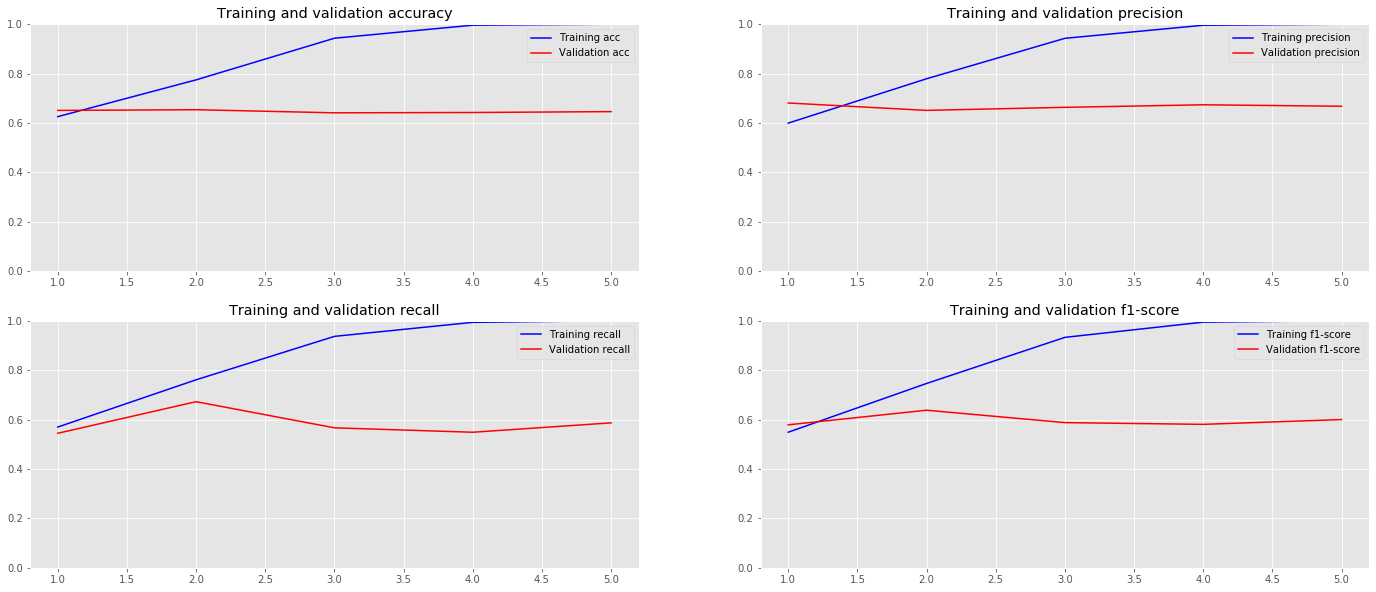

################################################
 

2019-11-20 23:29:13.064649
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 64s - loss: 0.6513 - acc: 0.6034 - f1_m: 0.5840 - precision_m: 0.5999 - recall_m: 0.6683 - val_loss: 0.6144 - val_acc: 0.6606 - val_f1_m: 0.6269 - val_precision_m: 0.6818 - val_recall_m: 0.6295
Epoch 2/5
 - 63s - loss: 0.5080 - acc: 0.7518 - f1_m: 0.7239 - precision_m: 0.7525 - recall_m: 0.7421 - val_loss: 0.6209 - val_acc: 0.6612 - val_f1_m: 0.6502 - val_precision_m: 0.6638 - val_recall_m: 0.6890
Epoch 3/5
 - 64s - loss: 0.2355 - acc: 0.9196 - f1_m: 0.9073 - precision_m: 0.9187 - recall_m: 0.9160 - val_loss: 0.7615 - val_acc: 0.6572 - val_f1_m: 0.6309 - val_precision_m: 0.6739 - val_recall_m: 0.6455
Epoch 4/5
 - 63s - loss: 0.0451 - acc: 0.9920 - f1_m: 0.9888 - precision_m: 0.9914 - recall_m: 0.9878 - val_loss: 0.9923 - val_acc: 0.6444 - val_f1_m: 0.5925 - val_precision_m: 0.6822 - val_recall_m: 0.5703
Epoch 5/5
 - 63s - loss: 0.0069 - acc: 0.999

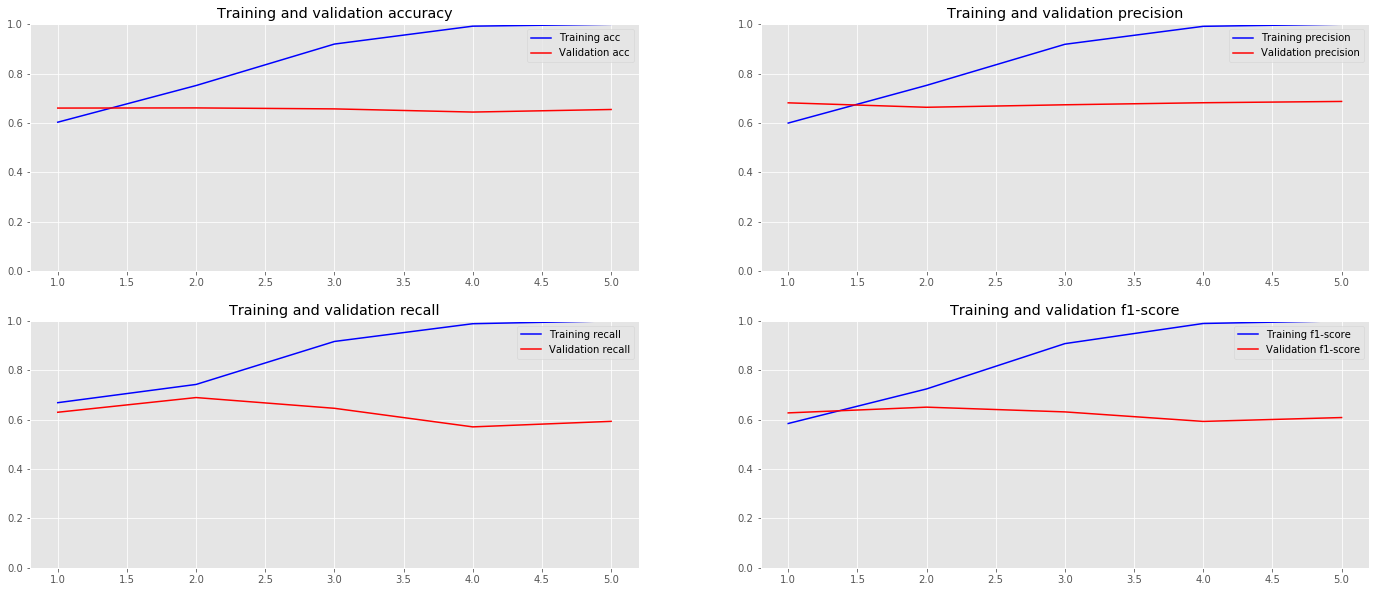

################################################
 

2019-11-20 23:34:45.158211
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 57s - loss: 0.6401 - acc: 0.6284 - f1_m: 0.5983 - precision_m: 0.6393 - recall_m: 0.6444 - val_loss: 0.6097 - val_acc: 0.6612 - val_f1_m: 0.6621 - val_precision_m: 0.6452 - val_recall_m: 0.7298
Epoch 2/5
 - 56s - loss: 0.4893 - acc: 0.7694 - f1_m: 0.7437 - precision_m: 0.7751 - recall_m: 0.7655 - val_loss: 0.6310 - val_acc: 0.6614 - val_f1_m: 0.6339 - val_precision_m: 0.6753 - val_recall_m: 0.6462
Epoch 3/5
 - 56s - loss: 0.1913 - acc: 0.9380 - f1_m: 0.9276 - precision_m: 0.9390 - recall_m: 0.9331 - val_loss: 0.8312 - val_acc: 0.6493 - val_f1_m: 0.6124 - val_precision_m: 0.6724 - val_recall_m: 0.6059
Epoch 4/5
 - 56s - loss: 0.0291 - acc: 0.9955 - f1_m: 0.9937 - precision_m: 0.9961 - recall_m: 0.9927 - val_loss: 1.0194 - val_acc: 0.6524 - val_f1_m: 0.6133 - val_precision_m: 0.6778 - val_recall_m: 0.6046
Epoch 5/5
 - 56s - loss: 0.0035 - acc: 0.999

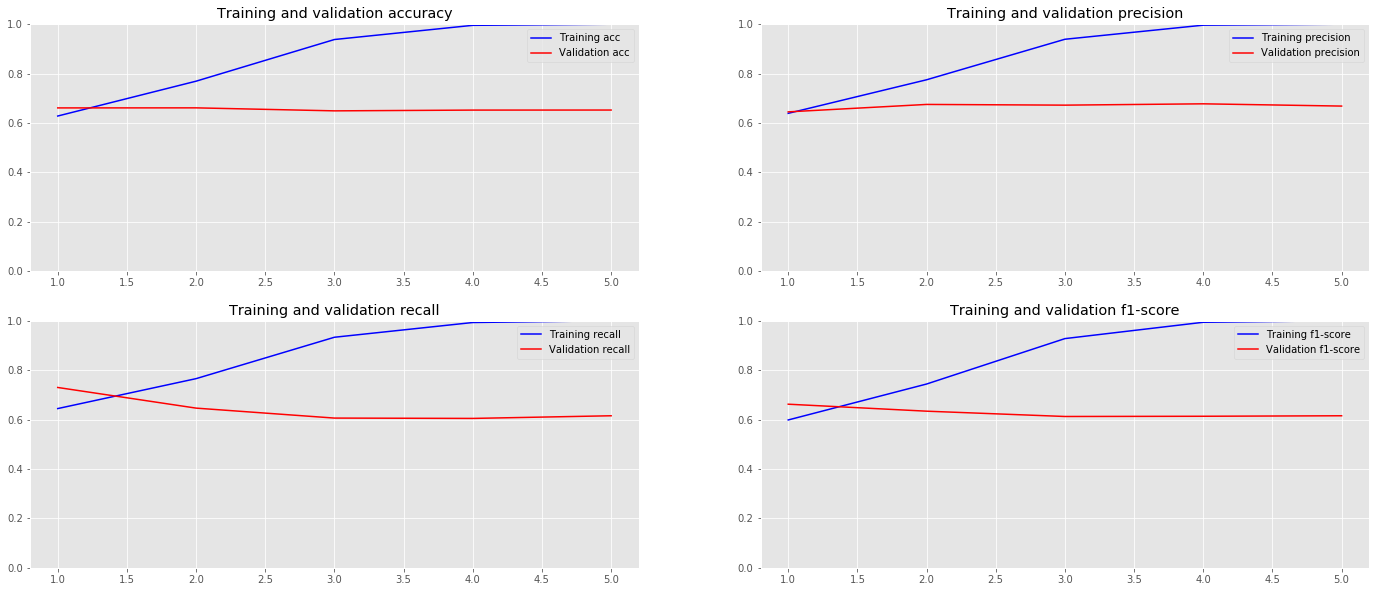

################################################
 

2019-11-20 23:39:41.411975
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 74s - loss: 0.6451 - acc: 0.6112 - f1_m: 0.4961 - precision_m: 0.5466 - recall_m: 0.5257 - val_loss: 0.6084 - val_acc: 0.6634 - val_f1_m: 0.6546 - val_precision_m: 0.6589 - val_recall_m: 0.6972
Epoch 2/5
 - 73s - loss: 0.4931 - acc: 0.7682 - f1_m: 0.7467 - precision_m: 0.7736 - recall_m: 0.7627 - val_loss: 0.6364 - val_acc: 0.6524 - val_f1_m: 0.6289 - val_precision_m: 0.6634 - val_recall_m: 0.6435
Epoch 3/5
 - 73s - loss: 0.1841 - acc: 0.9402 - f1_m: 0.9320 - precision_m: 0.9423 - recall_m: 0.9363 - val_loss: 1.0008 - val_acc: 0.6162 - val_f1_m: 0.4856 - val_precision_m: 0.6958 - val_recall_m: 0.4082
Epoch 4/5
 - 73s - loss: 0.0232 - acc: 0.9968 - f1_m: 0.9954 - precision_m: 0.9956 - recall_m: 0.9960 - val_loss: 1.2262 - val_acc: 0.6140 - val_f1_m: 0.5012 - val_precision_m: 0.6776 - val_recall_m: 0.4369
Epoch 5/5
 - 75s - loss: 0.0033 - acc: 0.999

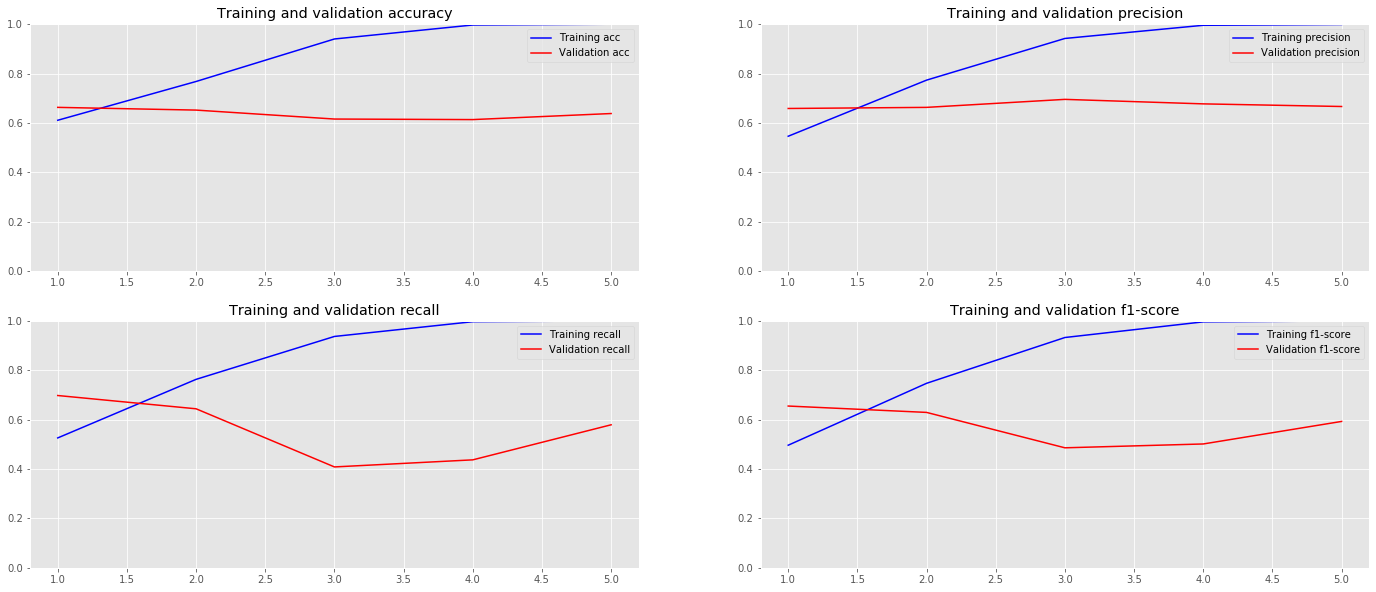

################################################
 

2019-11-20 23:46:10.569248
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 77s - loss: 0.6387 - acc: 0.6296 - f1_m: 0.5663 - precision_m: 0.6268 - recall_m: 0.5916 - val_loss: 0.6031 - val_acc: 0.6670 - val_f1_m: 0.6302 - val_precision_m: 0.6845 - val_recall_m: 0.6322
Epoch 2/5
 - 77s - loss: 0.4970 - acc: 0.7576 - f1_m: 0.7297 - precision_m: 0.7620 - recall_m: 0.7492 - val_loss: 0.6244 - val_acc: 0.6643 - val_f1_m: 0.6110 - val_precision_m: 0.6997 - val_recall_m: 0.5901
Epoch 3/5
 - 77s - loss: 0.2001 - acc: 0.9363 - f1_m: 0.9261 - precision_m: 0.9399 - recall_m: 0.9285 - val_loss: 0.8177 - val_acc: 0.6453 - val_f1_m: 0.6082 - val_precision_m: 0.6686 - val_recall_m: 0.6084
Epoch 4/5
 - 76s - loss: 0.0247 - acc: 0.9965 - f1_m: 0.9931 - precision_m: 0.9942 - recall_m: 0.9929 - val_loss: 1.0193 - val_acc: 0.6455 - val_f1_m: 0.6024 - val_precision_m: 0.6750 - val_recall_m: 0.5897
Epoch 5/5
 - 76s - loss: 0.0032 - acc: 0.999

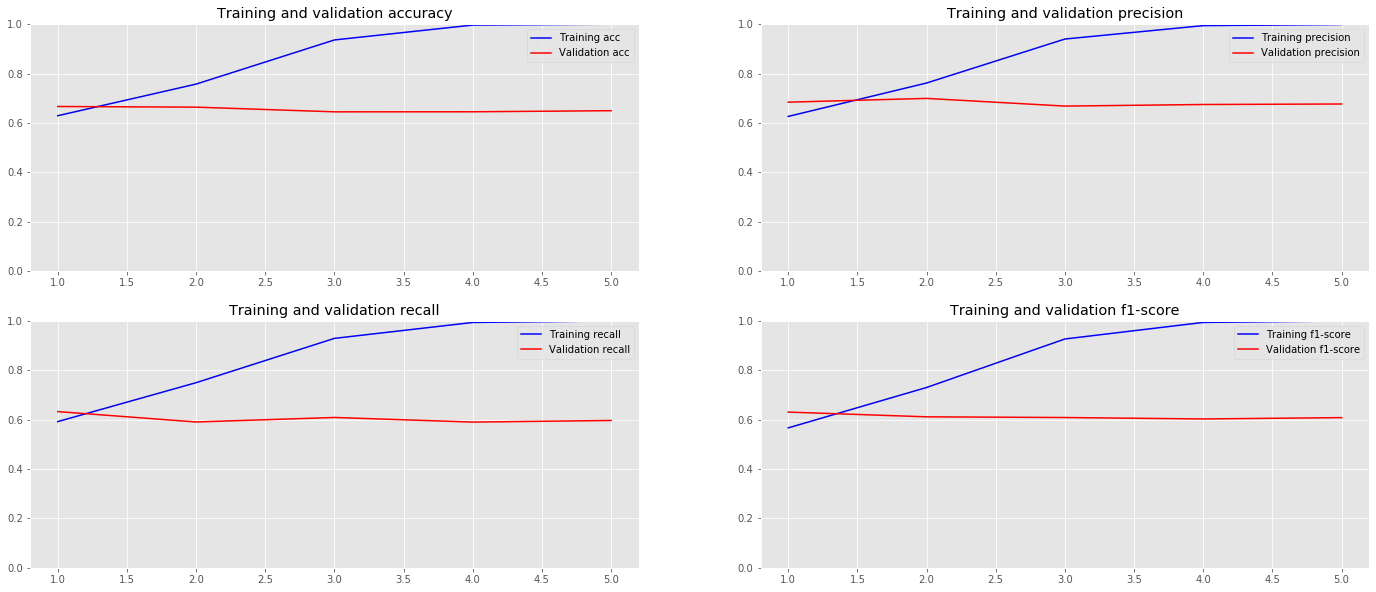

################################################
 

2019-11-20 23:52:57.901749
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 98s - loss: 0.6418 - acc: 0.6205 - f1_m: 0.4909 - precision_m: 0.5453 - recall_m: 0.5046 - val_loss: 0.6056 - val_acc: 0.6612 - val_f1_m: 0.6530 - val_precision_m: 0.6552 - val_recall_m: 0.6999
Epoch 2/5
 - 95s - loss: 0.4903 - acc: 0.7692 - f1_m: 0.7486 - precision_m: 0.7732 - recall_m: 0.7760 - val_loss: 0.6345 - val_acc: 0.6588 - val_f1_m: 0.6099 - val_precision_m: 0.6854 - val_recall_m: 0.5949
Epoch 3/5
 - 96s - loss: 0.1983 - acc: 0.9346 - f1_m: 0.9250 - precision_m: 0.9346 - recall_m: 0.9313 - val_loss: 0.8334 - val_acc: 0.6537 - val_f1_m: 0.6285 - val_precision_m: 0.6611 - val_recall_m: 0.6461
Epoch 4/5
 - 95s - loss: 0.0295 - acc: 0.9950 - f1_m: 0.9932 - precision_m: 0.9926 - recall_m: 0.9954 - val_loss: 1.1396 - val_acc: 0.6473 - val_f1_m: 0.6301 - val_precision_m: 0.6486 - val_recall_m: 0.6628
Epoch 5/5
 - 95s - loss: 0.0052 - acc: 0.999

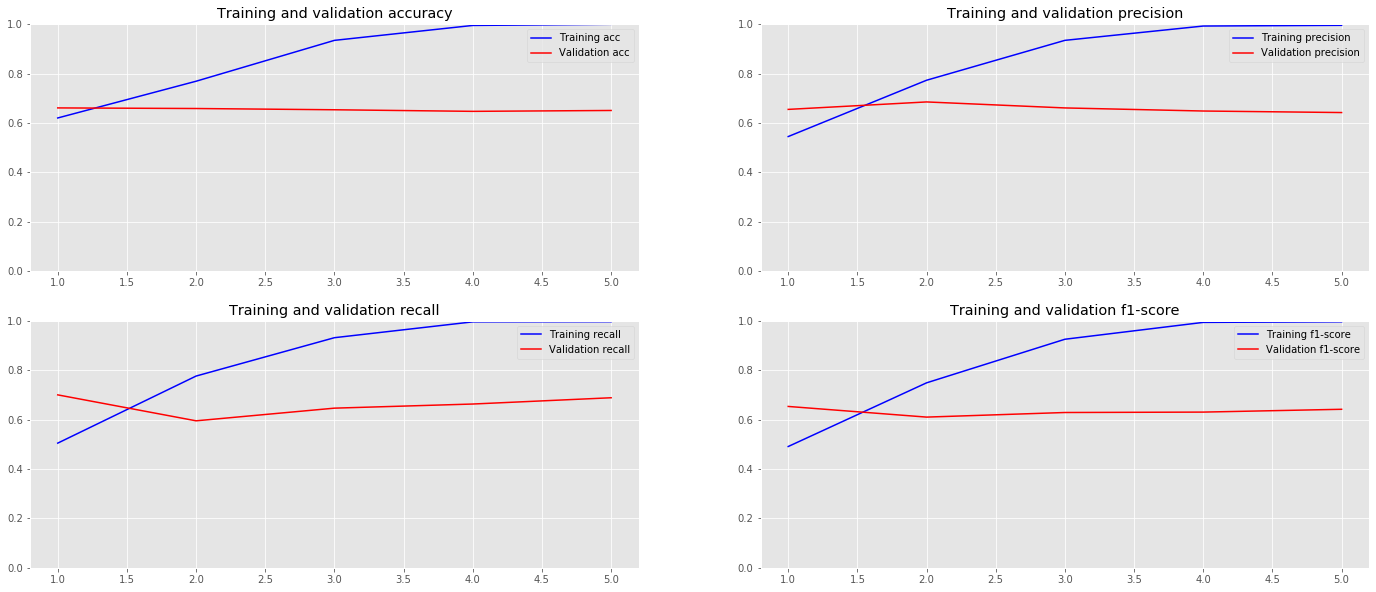

################################################
 

2019-11-21 00:01:24.786282
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 128s - loss: 0.6377 - acc: 0.6303 - f1_m: 0.5642 - precision_m: 0.6110 - recall_m: 0.5844 - val_loss: 0.6089 - val_acc: 0.6559 - val_f1_m: 0.6438 - val_precision_m: 0.6613 - val_recall_m: 0.6785
Epoch 2/5
 - 128s - loss: 0.4607 - acc: 0.7858 - f1_m: 0.7643 - precision_m: 0.7878 - recall_m: 0.7850 - val_loss: 0.7199 - val_acc: 0.6277 - val_f1_m: 0.5181 - val_precision_m: 0.6986 - val_recall_m: 0.4507
Epoch 3/5
 - 132s - loss: 0.1380 - acc: 0.9600 - f1_m: 0.9531 - precision_m: 0.9589 - recall_m: 0.9574 - val_loss: 0.8994 - val_acc: 0.6387 - val_f1_m: 0.6208 - val_precision_m: 0.6481 - val_recall_m: 0.6501
Epoch 4/5
 - 143s - loss: 0.0187 - acc: 0.9976 - f1_m: 0.9965 - precision_m: 0.9959 - recall_m: 0.9977 - val_loss: 1.1830 - val_acc: 0.6327 - val_f1_m: 0.5607 - val_precision_m: 0.6876 - val_recall_m: 0.5222
Epoch 5/5
 - 128s - loss: 0.0022 - acc: 

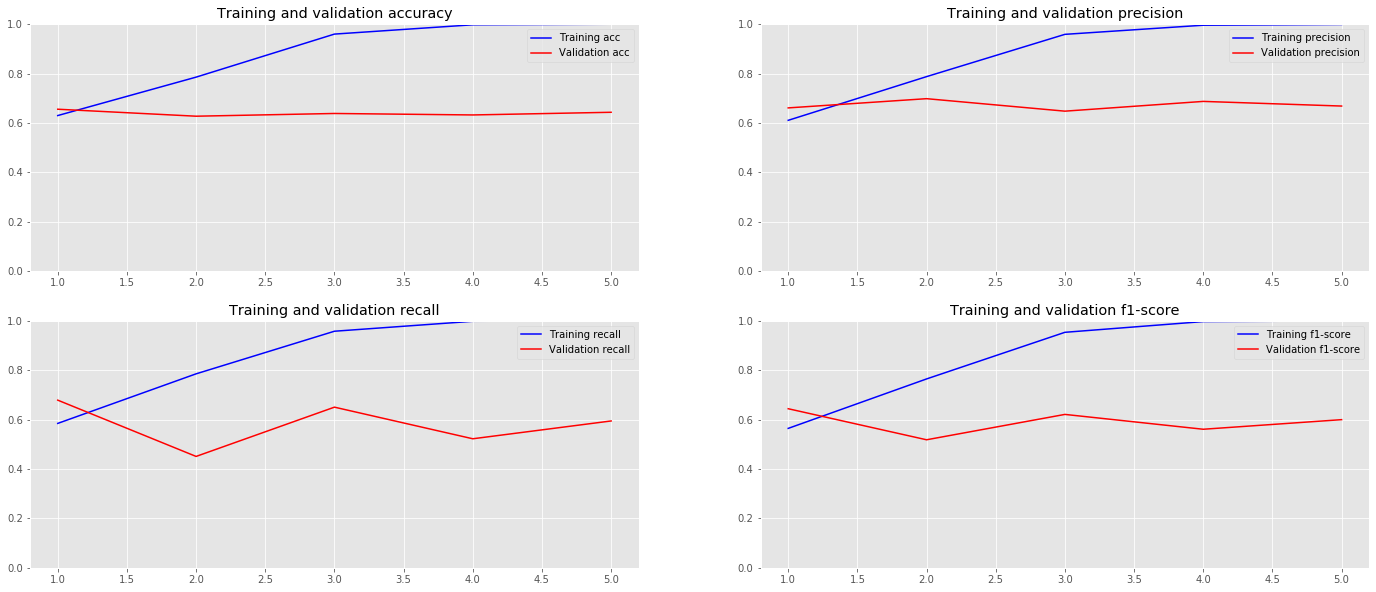

################################################
 

2019-11-21 00:12:50.079746
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 173s - loss: 0.6365 - acc: 0.6339 - f1_m: 0.5570 - precision_m: 0.6226 - recall_m: 0.5738 - val_loss: 0.6307 - val_acc: 0.6394 - val_f1_m: 0.6874 - val_precision_m: 0.6026 - val_recall_m: 0.8538
Epoch 2/5
 - 172s - loss: 0.4152 - acc: 0.8166 - f1_m: 0.7957 - precision_m: 0.8235 - recall_m: 0.8082 - val_loss: 0.7026 - val_acc: 0.6354 - val_f1_m: 0.5583 - val_precision_m: 0.6867 - val_recall_m: 0.5165
Epoch 3/5
 - 171s - loss: 0.0712 - acc: 0.9833 - f1_m: 0.9816 - precision_m: 0.9838 - recall_m: 0.9833 - val_loss: 0.9425 - val_acc: 0.6257 - val_f1_m: 0.5611 - val_precision_m: 0.6679 - val_recall_m: 0.5300
Epoch 4/5
 - 172s - loss: 0.0050 - acc: 0.9998 - f1_m: 0.9979 - precision_m: 0.9979 - recall_m: 0.9979 - val_loss: 1.1575 - val_acc: 0.6349 - val_f1_m: 0.5755 - val_precision_m: 0.6762 - val_recall_m: 0.5498
Epoch 5/5
 - 172s - loss: 5.7664e-04 - a

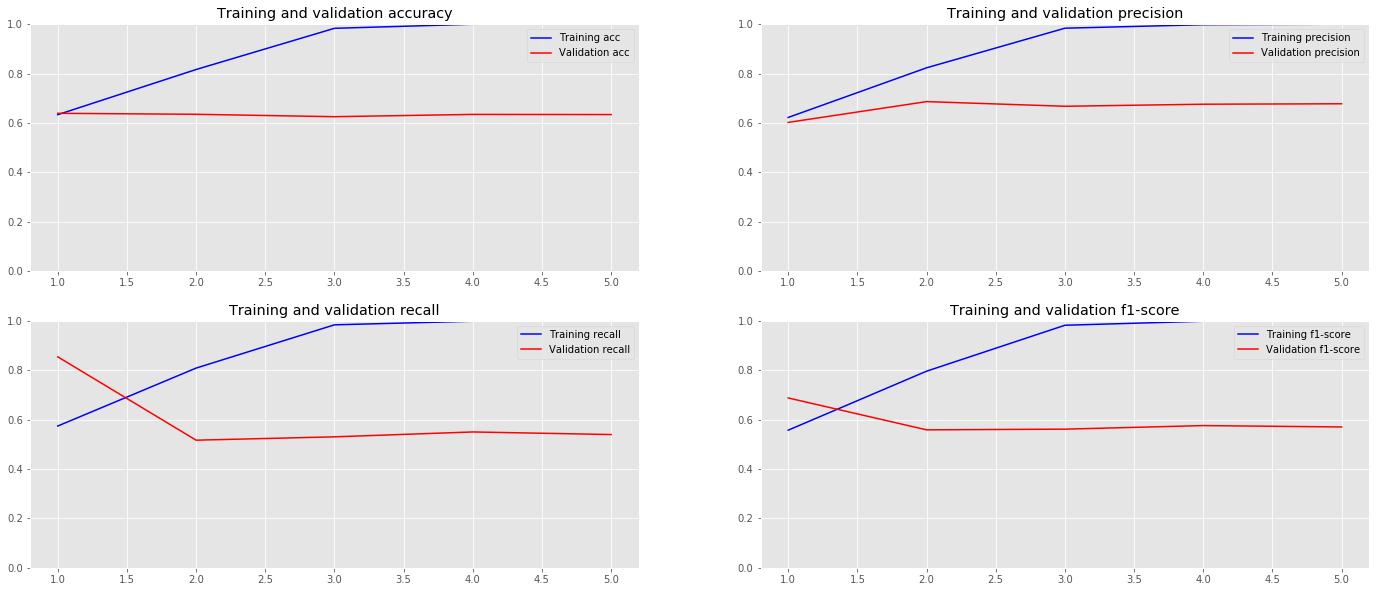

################################################
 

2019-11-21 00:27:41.631663
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 145s - loss: 0.6265 - acc: 0.6422 - f1_m: 0.5847 - precision_m: 0.6373 - recall_m: 0.6114 - val_loss: 0.6089 - val_acc: 0.6564 - val_f1_m: 0.6137 - val_precision_m: 0.6790 - val_recall_m: 0.6071
Epoch 2/5
 - 145s - loss: 0.3992 - acc: 0.8289 - f1_m: 0.8089 - precision_m: 0.8372 - recall_m: 0.8205 - val_loss: 0.8386 - val_acc: 0.6064 - val_f1_m: 0.4204 - val_precision_m: 0.6922 - val_recall_m: 0.3266
Epoch 3/5
 - 145s - loss: 0.0673 - acc: 0.9842 - f1_m: 0.9816 - precision_m: 0.9868 - recall_m: 0.9810 - val_loss: 0.9394 - val_acc: 0.6402 - val_f1_m: 0.6131 - val_precision_m: 0.6536 - val_recall_m: 0.6240
Epoch 4/5
 - 145s - loss: 0.0054 - acc: 0.9996 - f1_m: 0.9977 - precision_m: 0.9979 - recall_m: 0.9976 - val_loss: 1.0799 - val_acc: 0.6318 - val_f1_m: 0.5875 - val_precision_m: 0.6598 - val_recall_m: 0.5756
Epoch 5/5
 - 145s - loss: 8.3777e-04 - a

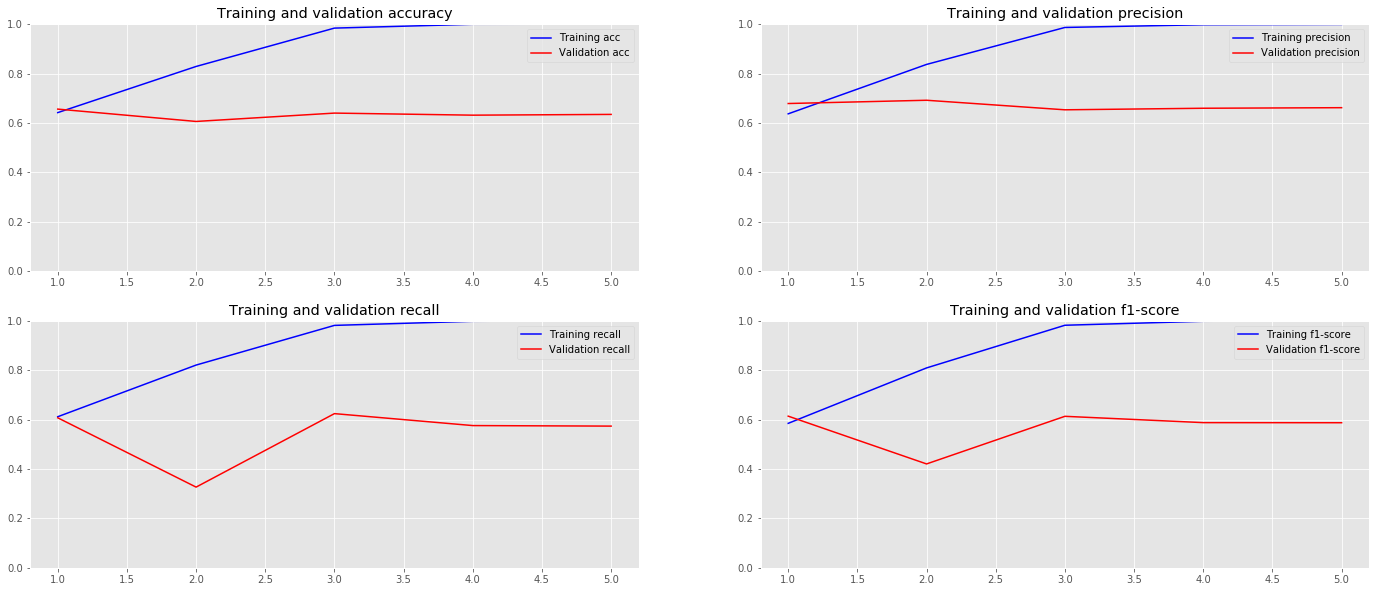

################################################
 

2019-11-21 00:40:20.020115
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 191s - loss: 0.6345 - acc: 0.6313 - f1_m: 0.5636 - precision_m: 0.6131 - recall_m: 0.5911 - val_loss: 0.6204 - val_acc: 0.6458 - val_f1_m: 0.5364 - val_precision_m: 0.7280 - val_recall_m: 0.4670
Epoch 2/5
 - 190s - loss: 0.3999 - acc: 0.8268 - f1_m: 0.8027 - precision_m: 0.8306 - recall_m: 0.8180 - val_loss: 0.6848 - val_acc: 0.6544 - val_f1_m: 0.6448 - val_precision_m: 0.6579 - val_recall_m: 0.6797
Epoch 3/5
 - 190s - loss: 0.0518 - acc: 0.9881 - f1_m: 0.9844 - precision_m: 0.9875 - recall_m: 0.9843 - val_loss: 0.9555 - val_acc: 0.6447 - val_f1_m: 0.5797 - val_precision_m: 0.6971 - val_recall_m: 0.5427
Epoch 4/5
 - 190s - loss: 0.0032 - acc: 0.9999 - f1_m: 0.9961 - precision_m: 0.9960 - recall_m: 0.9962 - val_loss: 1.0828 - val_acc: 0.6519 - val_f1_m: 0.6035 - val_precision_m: 0.6925 - val_recall_m: 0.5852
Epoch 5/5
 - 190s - loss: 5.7453e-04 - a

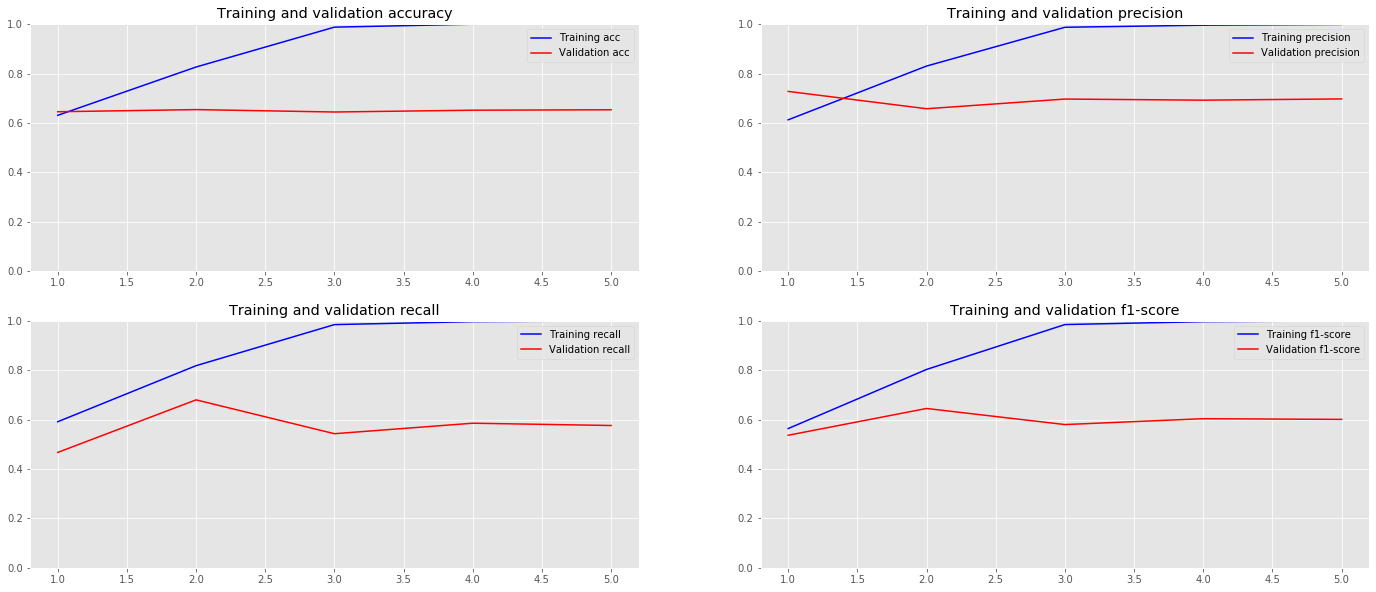

################################################
 

2019-11-21 00:56:52.325182
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 179s - loss: 0.6277 - acc: 0.6433 - f1_m: 0.6053 - precision_m: 0.6431 - recall_m: 0.6368 - val_loss: 0.6063 - val_acc: 0.6586 - val_f1_m: 0.6312 - val_precision_m: 0.6733 - val_recall_m: 0.6448
Epoch 2/5
 - 179s - loss: 0.4122 - acc: 0.8209 - f1_m: 0.7966 - precision_m: 0.8287 - recall_m: 0.8117 - val_loss: 0.6749 - val_acc: 0.6606 - val_f1_m: 0.6427 - val_precision_m: 0.6627 - val_recall_m: 0.6680
Epoch 3/5
 - 179s - loss: 0.0632 - acc: 0.9865 - f1_m: 0.9837 - precision_m: 0.9878 - recall_m: 0.9837 - val_loss: 0.8896 - val_acc: 0.6391 - val_f1_m: 0.6081 - val_precision_m: 0.6578 - val_recall_m: 0.6129
Epoch 4/5
 - 179s - loss: 0.0046 - acc: 0.9997 - f1_m: 0.9985 - precision_m: 0.9989 - recall_m: 0.9984 - val_loss: 1.0808 - val_acc: 0.6480 - val_f1_m: 0.6059 - val_precision_m: 0.6775 - val_recall_m: 0.5920
Epoch 5/5
 - 178s - loss: 6.7644e-04 - a

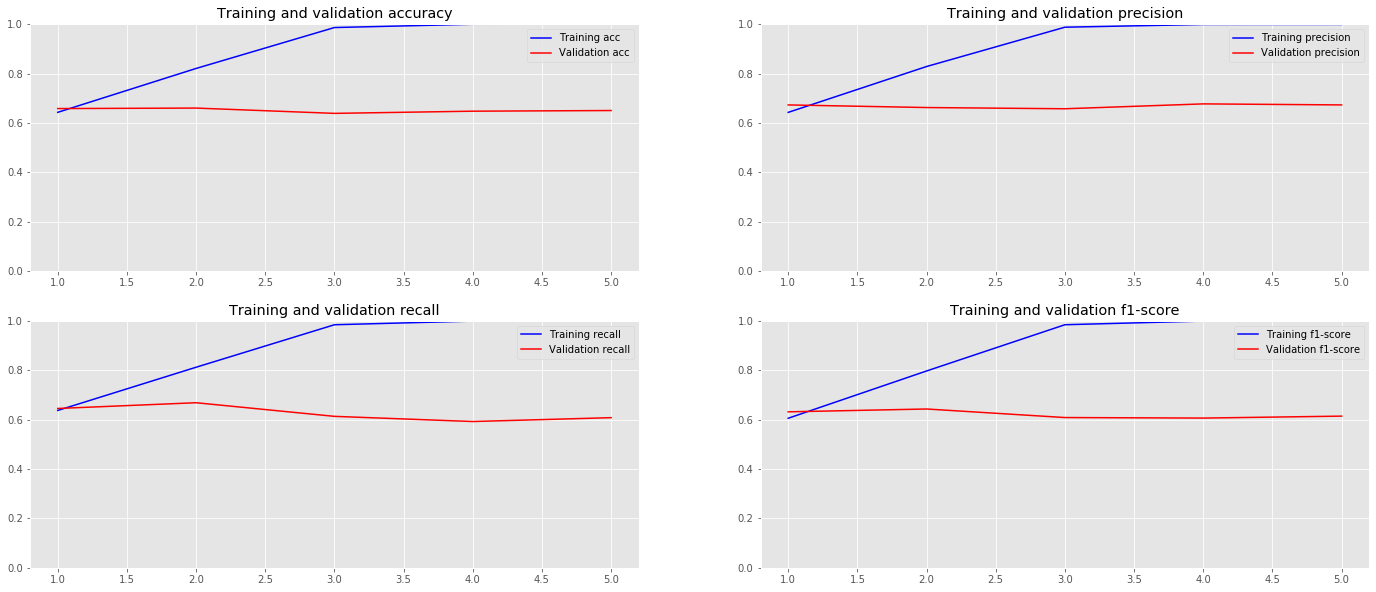

################################################
 

2019-11-21 01:12:33.994818
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 227s - loss: 0.6341 - acc: 0.6265 - f1_m: 0.5377 - precision_m: 0.5928 - recall_m: 0.5619 - val_loss: 0.6050 - val_acc: 0.6674 - val_f1_m: 0.6531 - val_precision_m: 0.6640 - val_recall_m: 0.6963
Epoch 2/5
 - 227s - loss: 0.4111 - acc: 0.8218 - f1_m: 0.7983 - precision_m: 0.8292 - recall_m: 0.8141 - val_loss: 0.7025 - val_acc: 0.6458 - val_f1_m: 0.6675 - val_precision_m: 0.6241 - val_recall_m: 0.7689
Epoch 3/5
 - 227s - loss: 0.0566 - acc: 0.9870 - f1_m: 0.9849 - precision_m: 0.9870 - recall_m: 0.9861 - val_loss: 0.9458 - val_acc: 0.6396 - val_f1_m: 0.5585 - val_precision_m: 0.6912 - val_recall_m: 0.5126
Epoch 4/5
 - 227s - loss: 0.0041 - acc: 0.9998 - f1_m: 0.9988 - precision_m: 0.9985 - recall_m: 0.9991 - val_loss: 1.0673 - val_acc: 0.6495 - val_f1_m: 0.6046 - val_precision_m: 0.6810 - val_recall_m: 0.5918
Epoch 5/5
 - 226s - loss: 5.2369e-04 - a

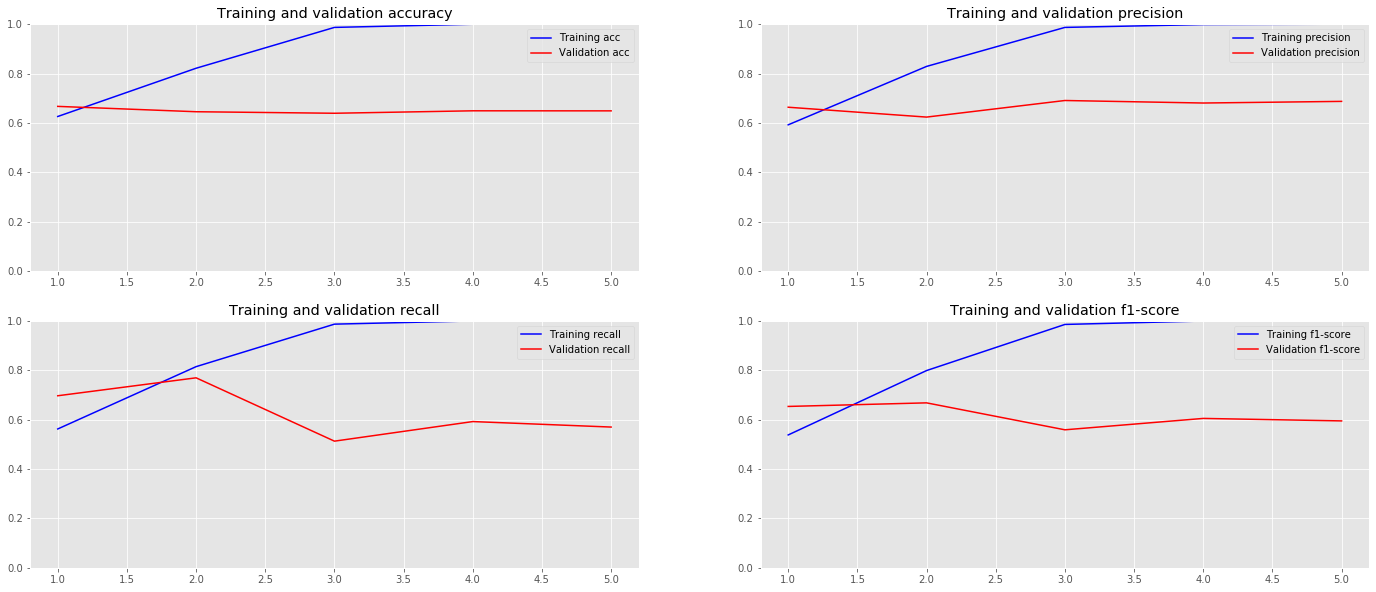

################################################
 

2019-11-21 01:32:29.148534
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 247s - loss: 0.6355 - acc: 0.6292 - f1_m: 0.5674 - precision_m: 0.6094 - recall_m: 0.5872 - val_loss: 0.6111 - val_acc: 0.6579 - val_f1_m: 0.6353 - val_precision_m: 0.6559 - val_recall_m: 0.6642
Epoch 2/5
 - 247s - loss: 0.4352 - acc: 0.8048 - f1_m: 0.7854 - precision_m: 0.8167 - recall_m: 0.8002 - val_loss: 0.6966 - val_acc: 0.6427 - val_f1_m: 0.6129 - val_precision_m: 0.6642 - val_recall_m: 0.6183
Epoch 3/5
 - 247s - loss: 0.1021 - acc: 0.9691 - f1_m: 0.9633 - precision_m: 0.9678 - recall_m: 0.9661 - val_loss: 0.9998 - val_acc: 0.6354 - val_f1_m: 0.5963 - val_precision_m: 0.6611 - val_recall_m: 0.5893
Epoch 4/5
 - 247s - loss: 0.0109 - acc: 0.9992 - f1_m: 0.9981 - precision_m: 0.9982 - recall_m: 0.9982 - val_loss: 1.1746 - val_acc: 0.6422 - val_f1_m: 0.5975 - val_precision_m: 0.6700 - val_recall_m: 0.5820
Epoch 5/5
 - 247s - loss: 0.0011 - acc: 

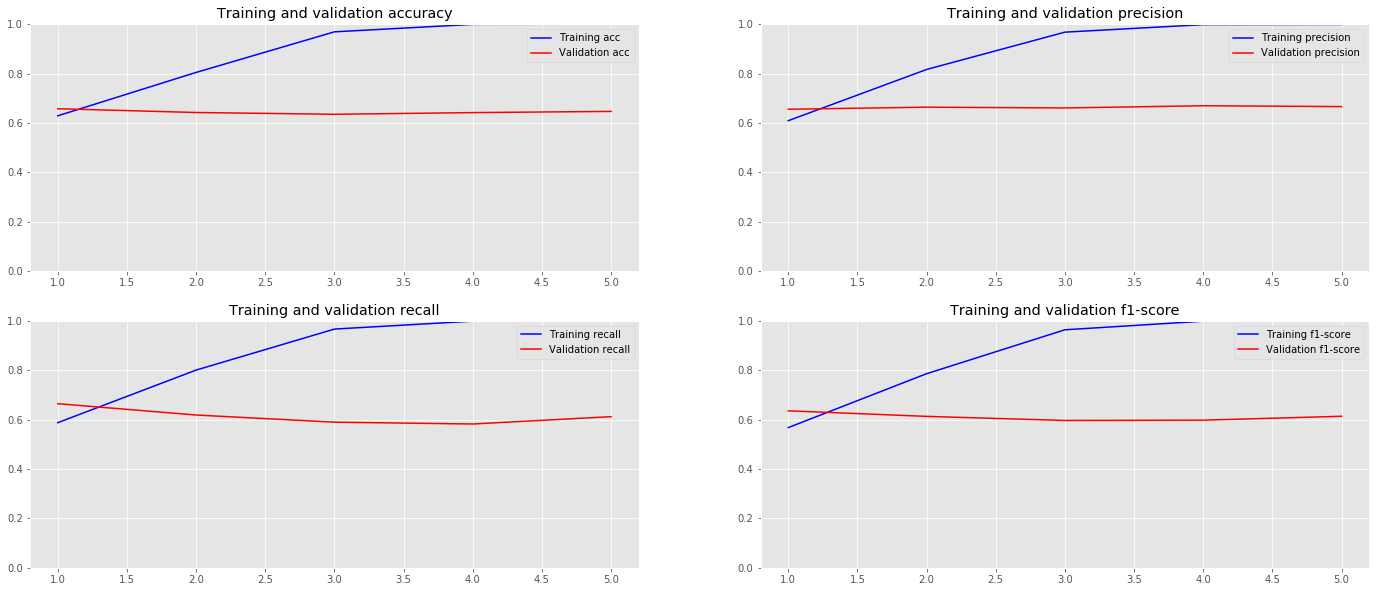

################################################
 

2019-11-21 01:53:52.013104
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 322s - loss: 0.6275 - acc: 0.6386 - f1_m: 0.5939 - precision_m: 0.6405 - recall_m: 0.6224 - val_loss: 0.6108 - val_acc: 0.6568 - val_f1_m: 0.6092 - val_precision_m: 0.6871 - val_recall_m: 0.5913
Epoch 2/5
 - 322s - loss: 0.3546 - acc: 0.8511 - f1_m: 0.8340 - precision_m: 0.8617 - recall_m: 0.8388 - val_loss: 0.7158 - val_acc: 0.6433 - val_f1_m: 0.6339 - val_precision_m: 0.6364 - val_recall_m: 0.6809
Epoch 3/5
 - 322s - loss: 0.0471 - acc: 0.9888 - f1_m: 0.9882 - precision_m: 0.9904 - recall_m: 0.9884 - val_loss: 1.0326 - val_acc: 0.6442 - val_f1_m: 0.5688 - val_precision_m: 0.6947 - val_recall_m: 0.5239
Epoch 4/5
 - 322s - loss: 0.0035 - acc: 0.9999 - f1_m: 0.9980 - precision_m: 0.9979 - recall_m: 0.9981 - val_loss: 1.1426 - val_acc: 0.6420 - val_f1_m: 0.5693 - val_precision_m: 0.6945 - val_recall_m: 0.5265
Epoch 5/5
 - 323s - loss: 5.7073e-04 - a

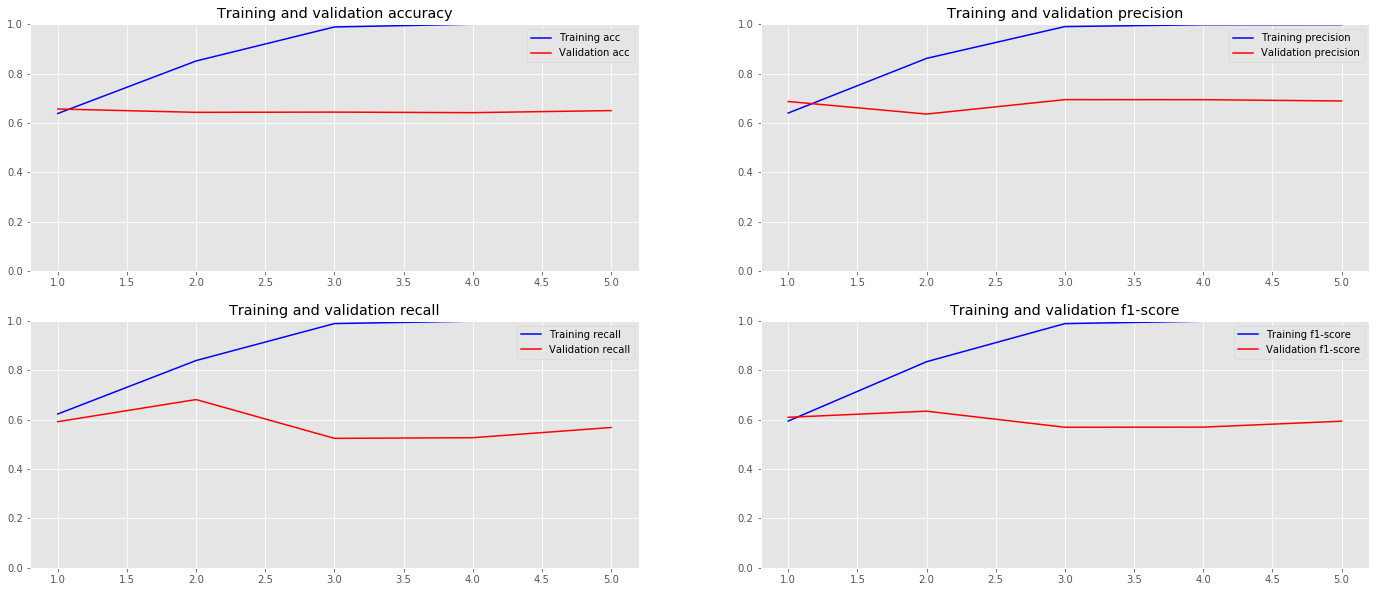

################################################
 

2019-11-21 02:21:38.422916
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 270s - loss: 0.6343 - acc: 0.6335 - f1_m: 0.5423 - precision_m: 0.5996 - recall_m: 0.5567 - val_loss: 0.6027 - val_acc: 0.6703 - val_f1_m: 0.6469 - val_precision_m: 0.6761 - val_recall_m: 0.6668
Epoch 2/5
 - 270s - loss: 0.4357 - acc: 0.8015 - f1_m: 0.7798 - precision_m: 0.8058 - recall_m: 0.7989 - val_loss: 0.6488 - val_acc: 0.6524 - val_f1_m: 0.6379 - val_precision_m: 0.6551 - val_recall_m: 0.6702
Epoch 3/5
 - 270s - loss: 0.0908 - acc: 0.9760 - f1_m: 0.9706 - precision_m: 0.9739 - recall_m: 0.9734 - val_loss: 1.1242 - val_acc: 0.6325 - val_f1_m: 0.5050 - val_precision_m: 0.7204 - val_recall_m: 0.4269
Epoch 4/5
 - 270s - loss: 0.0070 - acc: 0.9993 - f1_m: 0.9983 - precision_m: 0.9986 - recall_m: 0.9981 - val_loss: 1.0652 - val_acc: 0.6517 - val_f1_m: 0.6230 - val_precision_m: 0.6656 - val_recall_m: 0.6342
Epoch 5/5
 - 270s - loss: 0.0013 - acc: 

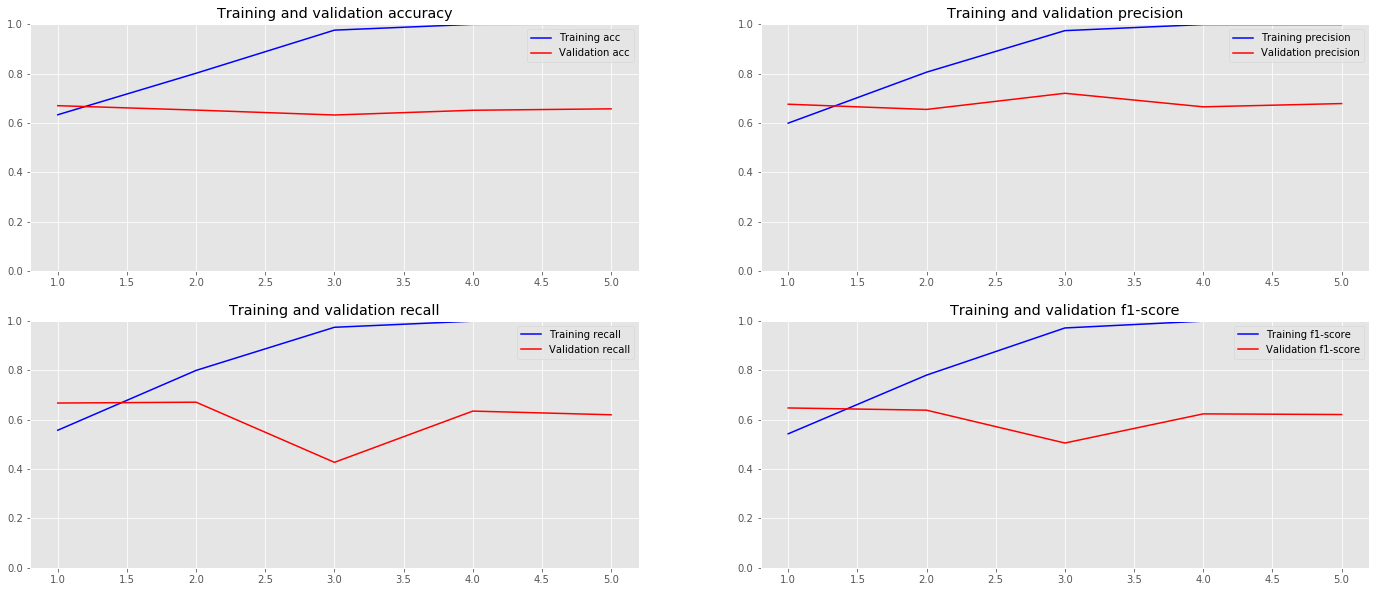

################################################
 

2019-11-21 02:45:08.908596
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 346s - loss: 0.6328 - acc: 0.6406 - f1_m: 0.5544 - precision_m: 0.5997 - recall_m: 0.5756 - val_loss: 0.6219 - val_acc: 0.6533 - val_f1_m: 0.5667 - val_precision_m: 0.7196 - val_recall_m: 0.5081
Epoch 2/5
 - 345s - loss: 0.3709 - acc: 0.8458 - f1_m: 0.8258 - precision_m: 0.8459 - recall_m: 0.8390 - val_loss: 0.7031 - val_acc: 0.6546 - val_f1_m: 0.6281 - val_precision_m: 0.6688 - val_recall_m: 0.6477
Epoch 3/5
 - 346s - loss: 0.0438 - acc: 0.9897 - f1_m: 0.9874 - precision_m: 0.9874 - recall_m: 0.9899 - val_loss: 0.8862 - val_acc: 0.6612 - val_f1_m: 0.6326 - val_precision_m: 0.6836 - val_recall_m: 0.6408
Epoch 4/5
 - 346s - loss: 0.0031 - acc: 0.9998 - f1_m: 0.9980 - precision_m: 0.9978 - recall_m: 0.9981 - val_loss: 1.0389 - val_acc: 0.6533 - val_f1_m: 0.5991 - val_precision_m: 0.6982 - val_recall_m: 0.5738
Epoch 5/5
 - 346s - loss: 5.3005e-04 - a

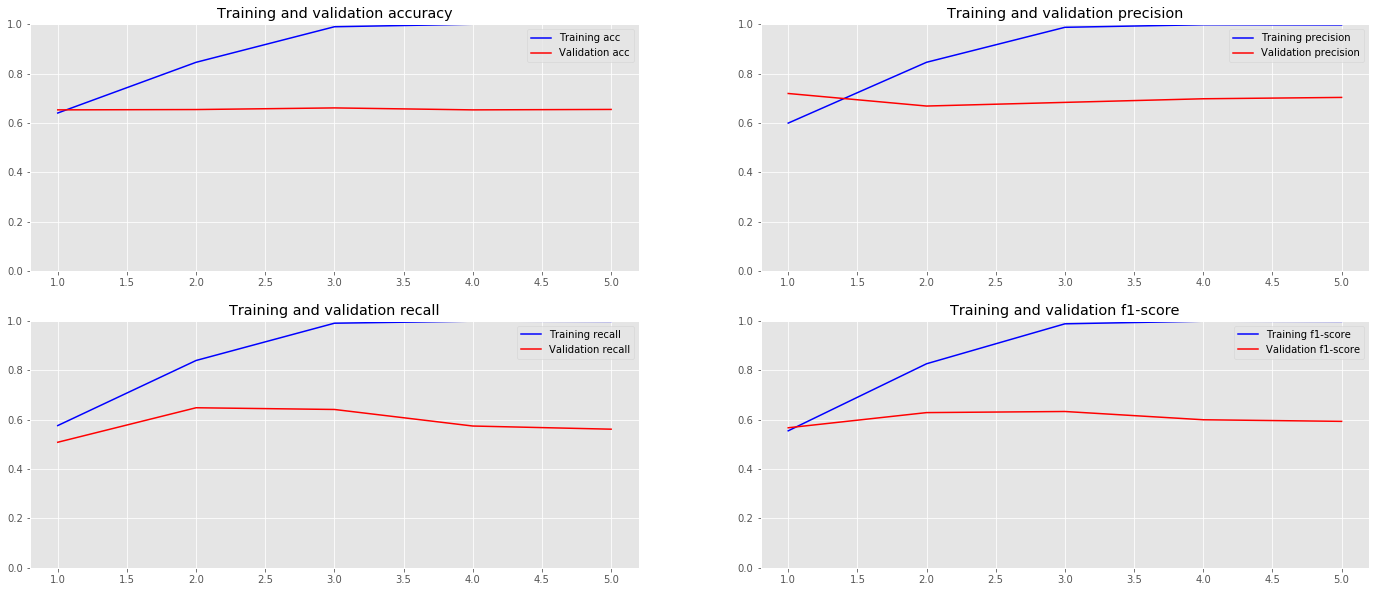

################################################
 

2019-11-21 03:15:11.546542
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 321s - loss: 0.6268 - acc: 0.6445 - f1_m: 0.5897 - precision_m: 0.6457 - recall_m: 0.6172 - val_loss: 0.6144 - val_acc: 0.6548 - val_f1_m: 0.5668 - val_precision_m: 0.7240 - val_recall_m: 0.5064
Epoch 2/5
 - 320s - loss: 0.3771 - acc: 0.8390 - f1_m: 0.8197 - precision_m: 0.8500 - recall_m: 0.8279 - val_loss: 0.6931 - val_acc: 0.6553 - val_f1_m: 0.6102 - val_precision_m: 0.6887 - val_recall_m: 0.5905
Epoch 3/5
 - 321s - loss: 0.0467 - acc: 0.9894 - f1_m: 0.9863 - precision_m: 0.9897 - recall_m: 0.9856 - val_loss: 0.9457 - val_acc: 0.6528 - val_f1_m: 0.6006 - val_precision_m: 0.6912 - val_recall_m: 0.5793
Epoch 4/5
 - 321s - loss: 0.0031 - acc: 0.9999 - f1_m: 0.9980 - precision_m: 0.9980 - recall_m: 0.9981 - val_loss: 1.0145 - val_acc: 0.6553 - val_f1_m: 0.6218 - val_precision_m: 0.6807 - val_recall_m: 0.6206
Epoch 5/5
 - 320s - loss: 5.0475e-04 - a

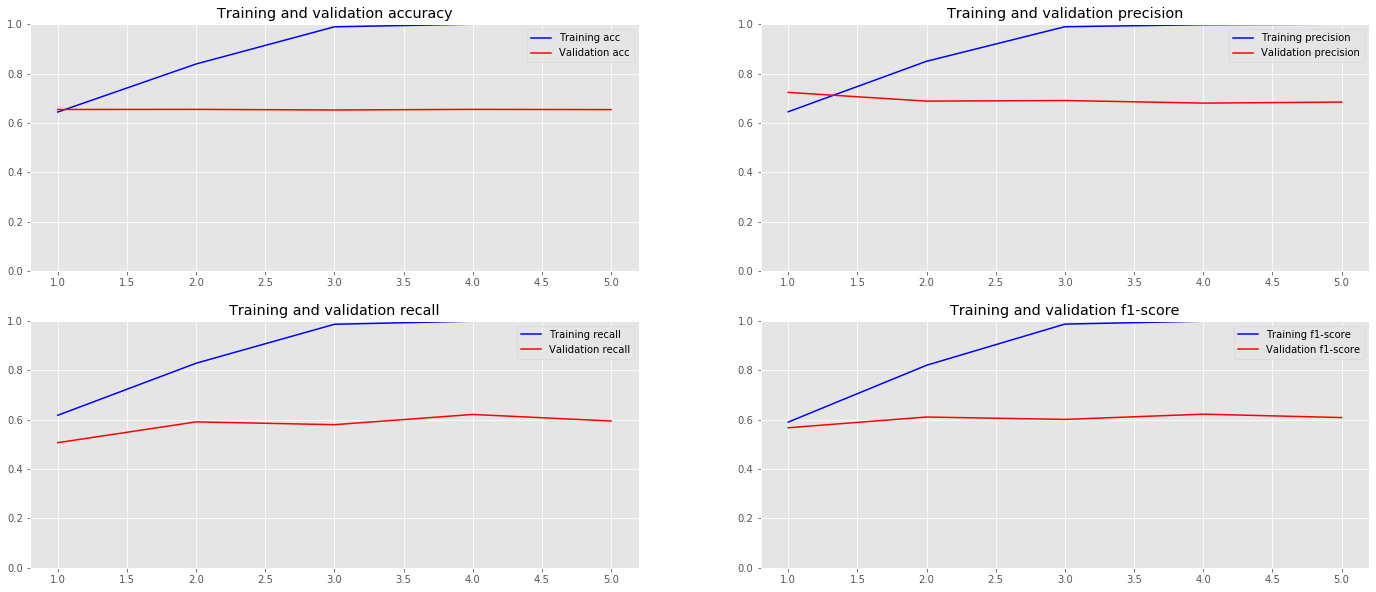

################################################
 

2019-11-21 03:43:18.913027
Train on 10564 samples, validate on 4528 samples
Epoch 1/5
 - 412s - loss: 0.6285 - acc: 0.6401 - f1_m: 0.5995 - precision_m: 0.6495 - recall_m: 0.6343 - val_loss: 0.6163 - val_acc: 0.6619 - val_f1_m: 0.6823 - val_precision_m: 0.6321 - val_recall_m: 0.7880
Epoch 2/5
 - 412s - loss: 0.3353 - acc: 0.8636 - f1_m: 0.8462 - precision_m: 0.8729 - recall_m: 0.8547 - val_loss: 0.7428 - val_acc: 0.6462 - val_f1_m: 0.6644 - val_precision_m: 0.6314 - val_recall_m: 0.7530
Epoch 3/5
 - 412s - loss: 0.0302 - acc: 0.9938 - f1_m: 0.9904 - precision_m: 0.9915 - recall_m: 0.9907 - val_loss: 1.0033 - val_acc: 0.6464 - val_f1_m: 0.5719 - val_precision_m: 0.7002 - val_recall_m: 0.5260
Epoch 4/5
 - 411s - loss: 0.0017 - acc: 1.0000 - f1_m: 0.9991 - precision_m: 0.9991 - recall_m: 0.9991 - val_loss: 1.0564 - val_acc: 0.6561 - val_f1_m: 0.6111 - val_precision_m: 0.6879 - val_recall_m: 0.5954
Epoch 5/5
 - 411s - loss: 3.4620e-04 - a

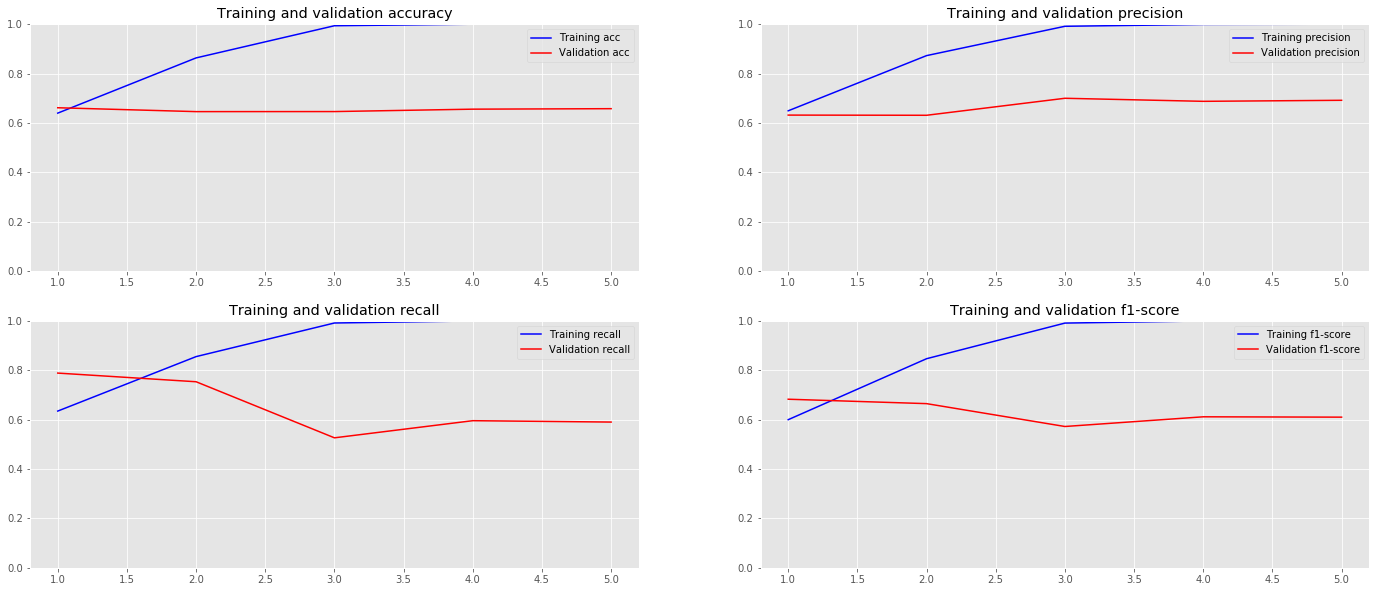

################################################
 

Wall time: 4h 54min 29s


In [31]:
%%time
print(datetime.datetime.now())

best_result = {'best_acc': 0., 'best_precision': 0., 'best_recall': 0., 'best_f1': 0.}
best_model = {'embedding_dim': 0., 'num_filters': 0., 'kernel_size:':0.}

for embedding_dim in list_embedding_dim:
    for num_filters in list_num_filters:
        for kernel_size in list_kernel_size:

            model = Sequential()
            model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
            model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
            model.add(layers.GlobalMaxPooling1D())
            model.add(layers.Dense(10, activation='relu'))
            model.add(layers.Dense(1, activation='sigmoid'))
            model.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['acc',f1_m,precision_m, recall_m])

            print(datetime.datetime.now())

            history = model.fit(x_train, y_train,
                       epochs = 5,
                       verbose=2,
                       validation_data=(x_test, y_test),
                       batch_size=10)
            
            print(datetime.datetime.now)
            loss, accuracy, f1_score, precision, recall = model.evaluate(x_train, y_train, verbose=False)
            print('############' + 'FOR KERNEL SIZE: ' + str(kernel_size) + ' NUM DIM: ' + str(embedding_dim) + ' NUM_FILTERS: ' + str(num_filters) +'############')
            print('Training Accuracy:', accuracy, '\nTraining Precision:', precision, '\nTraining Recall:', recall, '\nF1 Score:', f1_score)
            loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=False)
            print('\nTesting Accuracy:', accuracy, '\nTesting Precision:', precision, '\nTesting Recall:', recall, '\nF1 Score:', f1_score)
            plot_history(history)
            print('################################################\n \n')
            
            if(best_result.get('best_f1') < f1_score):
                best_result['best_acc'] = accuracy
                best_result['best_precision'] = precision
                best_result['best_recall'] = recall
                best_result['best_f1'] = f1_score
    
                best_model['embedding_dim'] = embedding_dim
                best_model['num_filters'] = num_filters
                best_model['kernel_size'] = kernel_size

In [32]:
# We print the best result and the hyperparameters used to obtain those results
print(best_result)
print(best_model)

{'best_acc': 0.6508392095565796, 'best_precision': 0.6458266973495483, 'best_recall': 0.6927197575569153, 'best_f1': 0.6612114310264587}
{'embedding_dim': 50, 'num_filters': 128, 'kernel_size:': 0.0, 'kernel_size': 5}


## 3.- Analysis of the results
After applying the grid search, our best result is 0.66 F1-Score (Since the dataset is balanced, the result of majority class would be 0.5, so we can consider this model better than majority class), that is the measure that we are trying to measure. We consider that this is a good result given the fact that spoiler detection is a very relative task, sometimes even for humans. Neverthelesss, we can observe in the graphics that there is overfitting in most of the cases, so maybe we could reduce the number of epochs (fortunatelly the history shows the results of previous epochs, so we don't need to compute again with a lower number of epochs). In the next notebook, we will apply these hyperparameters to a bigger part of the dataset, we didn't use more data for the grid search due to the large computation times (With the split we are going to use in the next book, it takes one hour and a half to compute one epoch).

The hyperparameters that have returned the best results are: **50 embedding dimensions**, a **kernel size of 5** and **128 filters**. Other possible hyperparameters could have been the vocabulary size (optional parameter ```num_words``` in the Tokenizer function), but we tested this value in a previous test and the only difference we noticed was that it took more epochs to obtain the same results (slower convergence). We also decided not to reduce the maximum length of a review (```max_len```) to avoid the loss of information (The spoilers could be at the end of a review).
<br>

In the next notebook, we will proceed to apply these hyperparameters to a bigger part of the dataset